In [7]:
from __future__ import print_function, division

import os
import fnmatch
from time import time

import numpy as np
import scipy as sp
import pandas as pd
import imageio

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from IPython.display import display

import matplotlib.pyplot as plt
plt.ion()
# set random seed for reproducibility
np.random.seed(31)

VERBOSE = 1

In [10]:
def report_to_table(report):
    """
    Convert classification report in 
    string form to a 2 dimensional array.
    """
    report = report.splitlines()
    res = []
    res.append(['']+report[0].split())
    for row in report[2:-2]:
       res.append(row.split())
    lr = report[-1].split()
    res.append([' '.join(lr[:3])]+lr[3:])
    return np.array(res)

In [11]:
# read image data and save as vectors
DATA_PATH = 'data/CroppedYale'
file_format = '*.pgm'

img_width, img_height = 168, 192
image_dimension = img_height*img_width
n_samples = 2424

image_vectors = np.empty(shape=(n_samples, image_dimension), dtype='float32')
labels = np.empty(shape=(n_samples, 1), dtype='U10')

print('Reading image data from:', DATA_PATH)
t0 = time()
index = 0
for dirpath, dirs, files in os.walk(DATA_PATH):
    for file_name in fnmatch.filter(files, file_format):
        image_path = os.path.join(dirpath, file_name)
        # read image from file
        image = imageio.imread(image_path, flatten=True)
        # flatten image
        image_vector = image.ravel()
        # check that image has the right dimensions
        if image_vector.shape[0] == image_dimension:
            # save image vector
            image_vectors[index, :] = image_vector
            
            # use directory name as label for sample
            labels[index, :] = os.path.basename(dirpath)
            
            index += 1
        else:
            if VERBOSE >= 2:
                print('Wrong dimensions:', image_path)

                
# store unique class names
class_names = np.sort(np.unique(labels))
n_classes = class_names.shape[0]

print(index, 'images read')
print(n_classes, 'unique labels')
print('done in %0.3fs' % (time() - t0))

Reading image data from: data/CroppedYale
2424 images read
38 unique labels
done in 1.341s


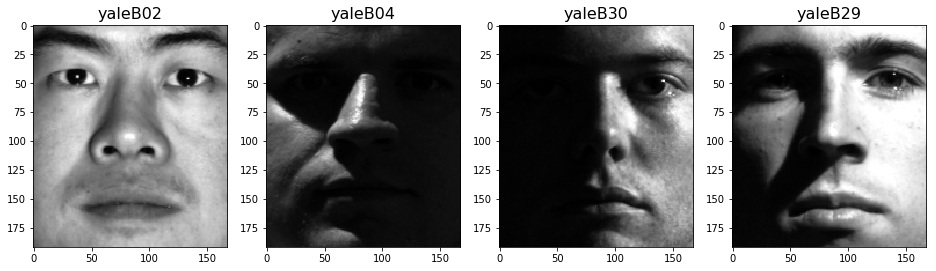

In [12]:
# plot random sample of images from the data set
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))
# choose random indices uniformly
random_index = np.random.choice(np.arange(n_samples), size=(4), replace=False)

for col, index in enumerate(random_index):
    ax[col].set_title(labels[index][0], fontsize=16)
    # reshape image to original dimensions
    image = image_vectors[index, :].reshape(img_height, img_width)
    # plot image
    ax[col].imshow(image, cmap=plt.cm.Greys_r)

plt.savefig('report/image_sample.png', bbox_inches='tight')
plt.show()

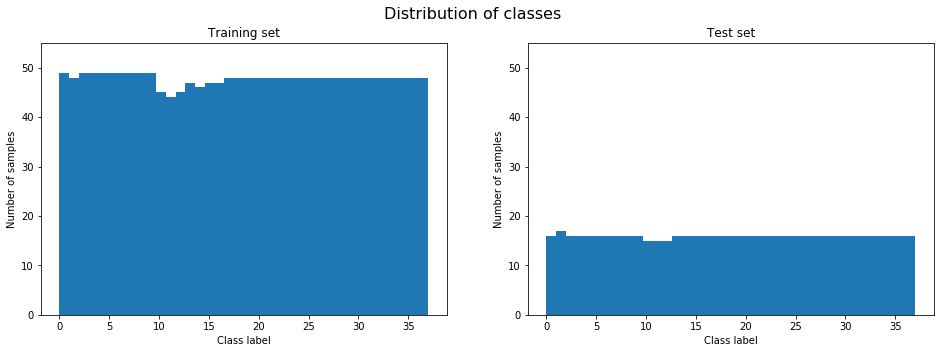

In [13]:
# get feature data
X = image_vectors

# encode labels as numbers
encoder = LabelEncoder()
y = encoder.fit_transform(labels.ravel())

# shuffle and split data into training and test sets
# data is stratified so we get approximately and equal number of 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, shuffle=True)

# plot distribution of classes in training and test sets
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 5))

ax[0].hist(y_train, bins=n_classes)
ax[0].set_title('Training set')
ax[0].set_xlabel('Class label')
ax[0].set_ylabel('Number of samples')
ax[0].set_ylim(0, 55)

ax[1].hist(y_test, bins=n_classes)
ax[1].set_title('Test set')
ax[1].set_xlabel('Class label')
ax[1].set_ylabel('Number of samples')
ax[1].set_ylim(0, 55)

plt.suptitle('Distribution of classes', fontsize=16)
plt.savefig('report/class_distribution.png', bbox_inches='tight')

plt.show()

In [14]:
# reduce dimensionality using principal component analysis

# Eigenfaces
n_components = 100

print('Performing dimensionality reduction using PCA')
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca.fit(X_train)
print('done in %0.3fs' % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, img_height, img_width))

# Projecting the input data on the eigenfaces orthonormal basis
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Performing dimensionality reduction using PCA
done in 4.701s


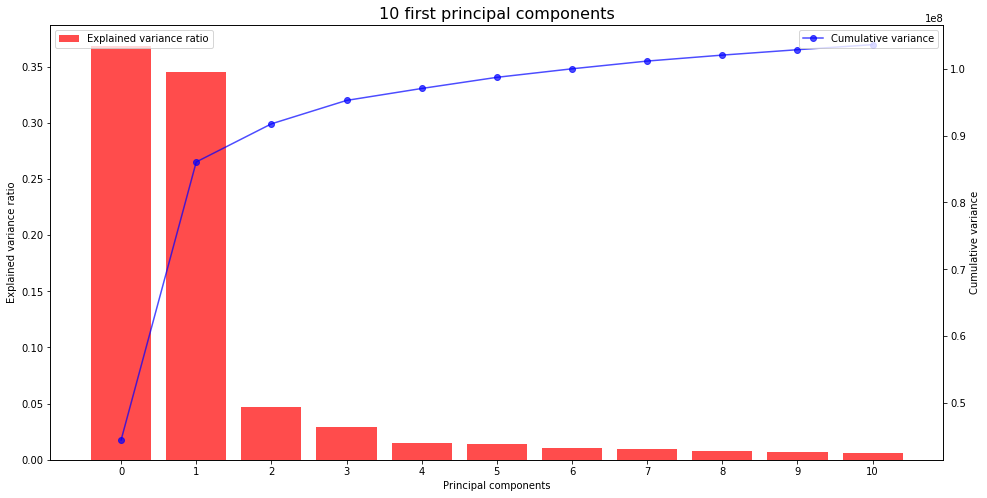

In [15]:
# plot 10 first principal components
fig, ax1 = plt.subplots(figsize=(16, 8))

index = np.arange(11)
cumulative_variance = np.cumsum(pca.explained_variance_[index])


ax1.bar(index, pca.explained_variance_ratio_[index], color='r', 
        alpha=0.7, label='Explained variance ratio')
ax1.set_ylabel('Explained variance ratio')
ax1.legend(loc='upper left')
ax1.set_xticks(index)
ax1.set_xlabel('Principal components')


ax2 = ax1.twinx()
# plot cumulative variance, scale on right y-axis
ax2.plot(index, cumulative_variance, 'bo-', 
         alpha=0.7, label='Cumulative variance')
ax2.set_ylabel('Cumulative variance')
ax2.legend(loc='upper right')

plt.title('10 first principal components', fontsize=16)
plt.savefig('report/principal_components.png', bbox_inches='tight')
plt.show()

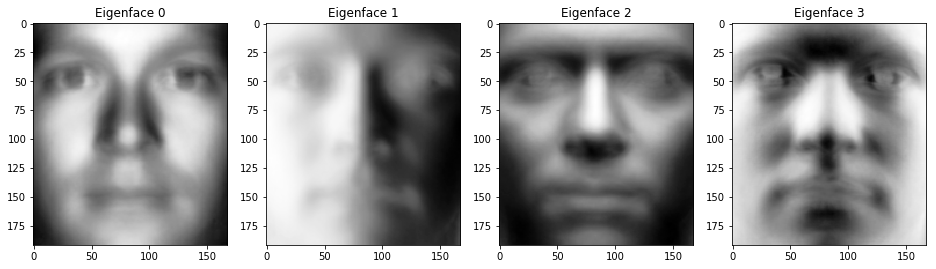

In [16]:
# show 4 first eigenfaces
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(16, 5))

for ix in range(4):
    ax[ix].set_title('Eigenface {}'.format(ix))
    # plot image
    ax[ix].imshow(eigenfaces[ix, :], cmap=plt.cm.Greys_r)

plt.savefig('report/eigenfaces.png', bbox_inches='tight')
plt.show()

In [ ]:
# search for good hyper-parameter for k-neareset neighbors classifier
model = KNeighborsClassifier()
print('Performing hyperparameter tuning for {} model using grid search'.format(model.__class__))
t0 = time()
param_grid = {'n_neighbors': [1, 2, 3, 4, 5]}
grid = GridSearchCV(model, param_grid, verbose=VERBOSE, 
                    n_jobs=-1, cv=5, scoring='f1_macro',
                    refit=True)

grid.fit(X_train_pca, y_train)
print("Best estimator found by grid search:\n", grid.best_estimator_)
print('done in %0.3fs' % (time() - t0))

In [16]:
y_pred = grid.best_estimator_.predict(X_test_pca)

# create classification report
report = classification_report(y_test, y_pred, target_names=class_names)

report_table = report_to_table(report)

report_df = pd.DataFrame(report_table[1:], columns=report_table[0])
report_df.rename(columns={'': 'class'}, inplace=True)
report_df.set_index('class', inplace=True)
report_df.to_csv('report/classification_report.csv')
display(report_df)

precision recall f1-score support
class                                        
yaleB01          0.80   1.00     0.89      16
yaleB02          0.93   0.82     0.87      17
yaleB03          0.89   1.00     0.94      16
yaleB04          0.83   0.94     0.88      16
yaleB05          1.00   0.94     0.97      16
yaleB06          1.00   0.81     0.90      16
yaleB07          0.84   1.00     0.91      16
yaleB08          0.94   0.94     0.94      16
yaleB09          1.00   1.00     1.00      16
yaleB10          0.87   0.81     0.84      16
yaleB11          1.00   0.80     0.89      15
yaleB12          1.00   1.00     1.00      15
yaleB13          0.93   0.93     0.93      15
yaleB15          1.00   1.00     1.00      16
yaleB16          0.92   0.69     0.79      16
yaleB17          1.00   1.00     1.00      16
yaleB18          1.00   0.94     0.97      16
yaleB19          0.93   0.88     0.90      16
yaleB20          0.82   0.88     0.85      16
yaleB21          0.83   0.94     0.88      16
yaleB22          1.00   0.94     0.97      16
yaleB23          1.00   0.81     0.90      16
yaleB24          1.00   0.88     0.93      16
yaleB25          1.00   0.88     0.93      16
yaleB26          0.88   0.94     0.91      16
yaleB27          1.00   0.94     0.97      16
yaleB28          0.94   1.00     0.97      16
yaleB29          1.00   0.94     0.97      16
yaleB30          1.00   0.94     0.97      16
yaleB31          1.00   0.94     0.97      16
yaleB32          0.79   0.94     0.86      16
yaleB33          0.81   0.81     0.81      16
yaleB34          0.84   1.00     0.91      16
yaleB35          0.82   0.88     0.85      16
yaleB36          0.88   0.88     0.88      16
yaleB37          0.76   1.00     0.86      16
yaleB38          0.88   0.94     0.91      16
yaleB39          1.00   0.94     0.97      16
avg / total      0.92   0.92     0.92     606

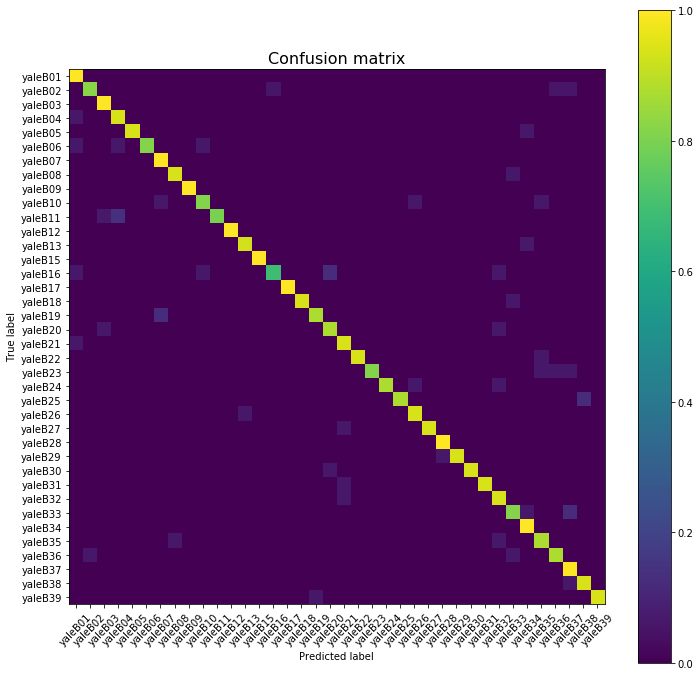

In [14]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.imshow(cnf_matrix, interpolation='nearest')
ax.set_title('Confusion matrix', fontsize=16)
fig.colorbar(cax)
tick_marks = np.arange(len(class_names))
ax.set_xticks(tick_marks)
ax.set_xticklabels(class_names, rotation=45)
ax.set_yticks(tick_marks)
ax.set_yticklabels(class_names)

ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

plt.savefig('report/confusion_matrix.png', bbox_inches='tight')
plt.show()

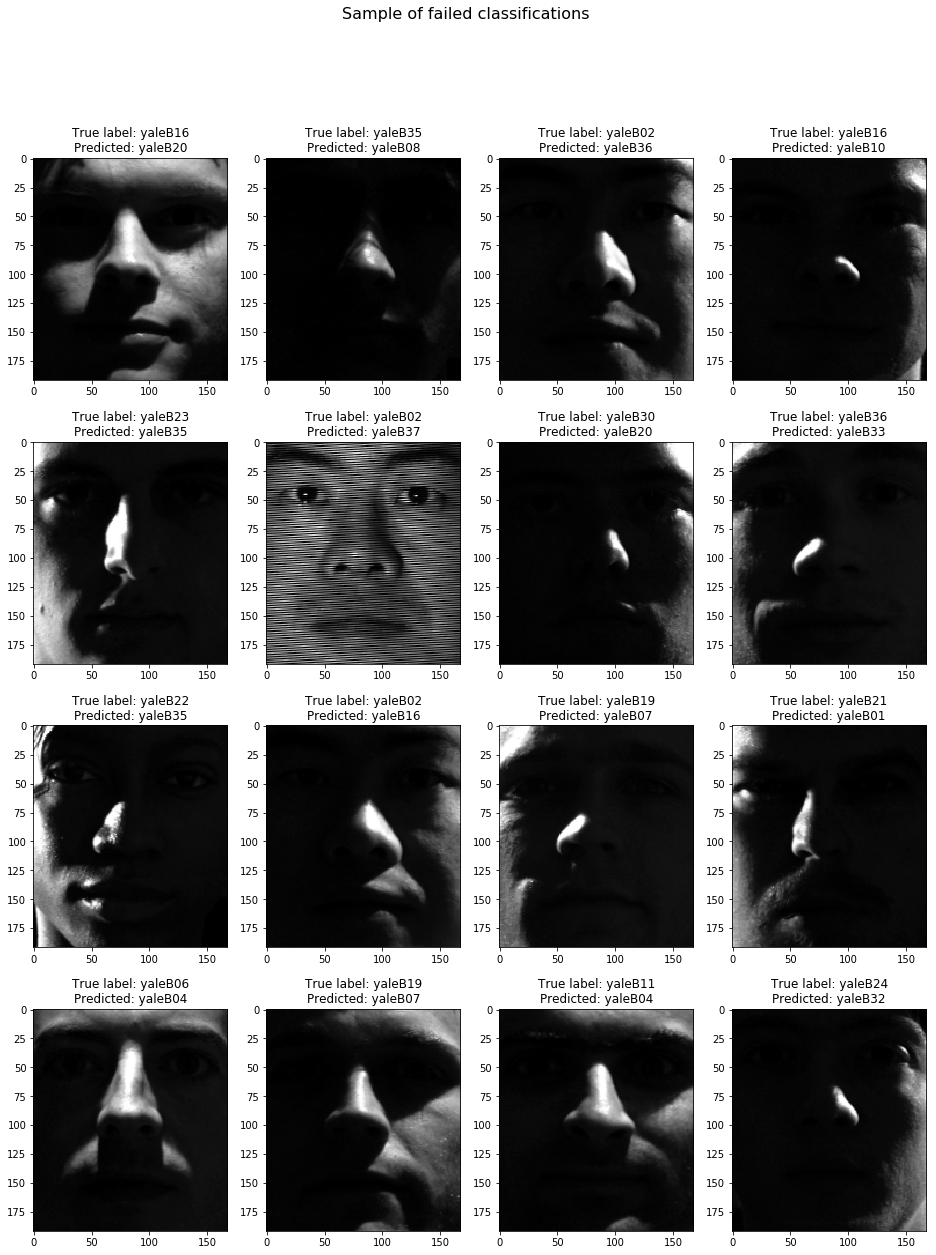

In [12]:
# show a number of failed classifications

# decode class label names from predicted and true encoded classes
true_classes = encoder.inverse_transform(y_test)
pred_classes = encoder.inverse_transform(y_pred)


ROWS, COLS = 4, 4
# choose a number of random failed classifications
error_index = np.random.choice(np.argwhere(y_pred != y_test).ravel(), 
                               ROWS*COLS, replace=False)

fig, ax = plt.subplots(ncols=COLS, nrows=ROWS, figsize=(16, 20))

for ix, err_ix in enumerate(error_index):
    rix, cix = divmod(ix, COLS)
    
    true = true_classes[err_ix]
    pred = pred_classes[err_ix]
    title = 'True label: {}\nPredicted: {}'.format(true, pred)
    ax[rix, cix].set_title(title)
    
    image = X_test[err_ix].reshape(img_height, img_width)
    # plot image
    ax[rix, cix].imshow(image, cmap=plt.cm.Greys_r)
    
plt.suptitle('Sample of failed classifications', fontsize=16)
plt.savefig('report/wrong_predictions.png', bbox_inches='tight')
plt.show(block=True)